In [2]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import precision_recall_curve

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

from sklearn.linear_model import SGDClassifier

from sklearn.multiclass import OneVsRestClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier


Feature shape: (70000, 784)
Target shape: (70000,)


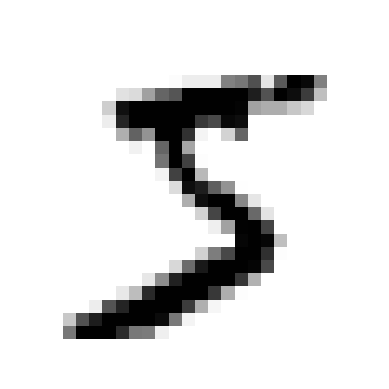

In [4]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

X, y = mnist["data"], mnist["target"]

print(f"Feature shape: {X.shape}")
print(f"Target shape: {y.shape}")

some_digit = X.iloc[0]
some_digit_image = some_digit.values.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()
y[0]
y = y.astype(np.uint8) 

In [5]:
X_train, X_test, y_train, y_test = X.iloc[:60000], X.iloc[60000:], y.iloc[:60000], y.iloc[60000:]

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print('SGD Classifier Percent Accurate:')
    print(n_correct / len(y_pred))
    
print('--')

print('SGD Classifier Cross Validation:')
print(cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy'))
print('--')

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

print('SGD Classifier Confusion Matrix, Precision, Recall and F1 Score:')
print(confusion_matrix(y_train_5, y_train_pred))
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))
print(f1_score(y_train_5, y_train_pred))

SGD Classifier Percent Accurate:
0.9669
SGD Classifier Percent Accurate:
0.91625
SGD Classifier Percent Accurate:
0.96785
--
SGD Classifier Cross Validation:
[0.95035 0.96035 0.9604 ]
--
SGD Classifier Confusion Matrix, Precision, Recall and F1 Score:
[[53892   687]
 [ 1891  3530]]
0.8370879772350012
0.6511713705958311
0.7325171197343847


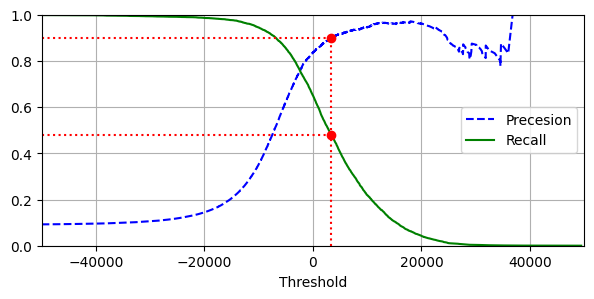

In [38]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precesions, recalls, thresholds):
    plt.plot(thresholds, precesions[:-1], "b--", label='Precesion')
    plt.plot(thresholds, recalls[:-1], 'g', label='Recall')
    plt.legend(loc="center right", fontsize=10) 
    plt.xlabel("Threshold", fontsize=10)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1]) 
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(7,3))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show() 

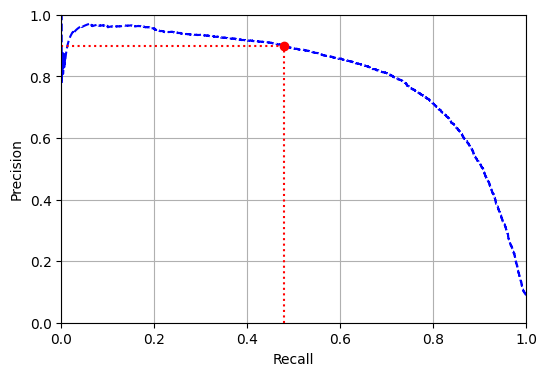

In [31]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls,precisions, "b--")
    plt.xlabel("Recall", fontsize=10)
    plt.ylabel("Precision", fontsize=10)
    plt.grid(True)
    plt.axis([0,1,0,1])

plt.figure(figsize=(6,4))
plot_precision_vs_recall(precisions,recalls)
plt.plot([recall_90_precision, recall_90_precision],[0.0, 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [27]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

y_train_pred_90 = (y_scores >= threshold_90_precision)

print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

3370.0194991439557
0.9000345901072293
0.4799852425751706


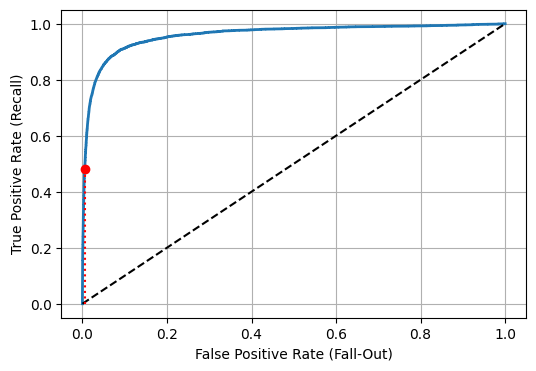

0.9604938554008616

In [34]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate (Fall-Out)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.grid(True)


plt.figure(figsize=(6,4))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro") 
plt.show()

roc_auc_score(y_train_5, y_scores)

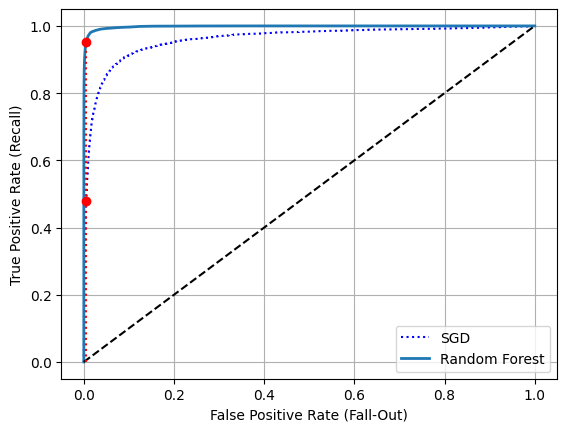

In [35]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate (Fall-Out)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.grid(True)

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

In [ ]:
svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

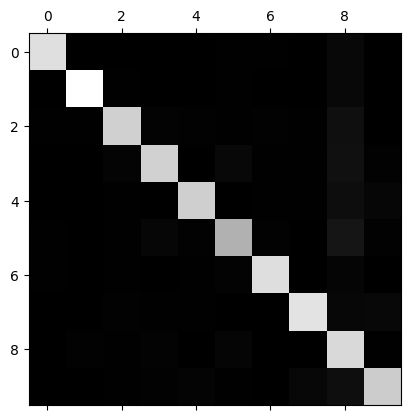

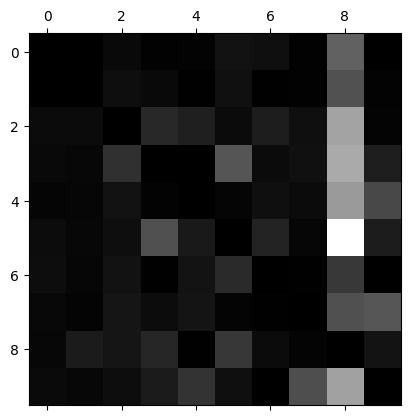

In [6]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])
sgd_clf.decision_function([some_digit])

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

conf_mx = confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [14]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

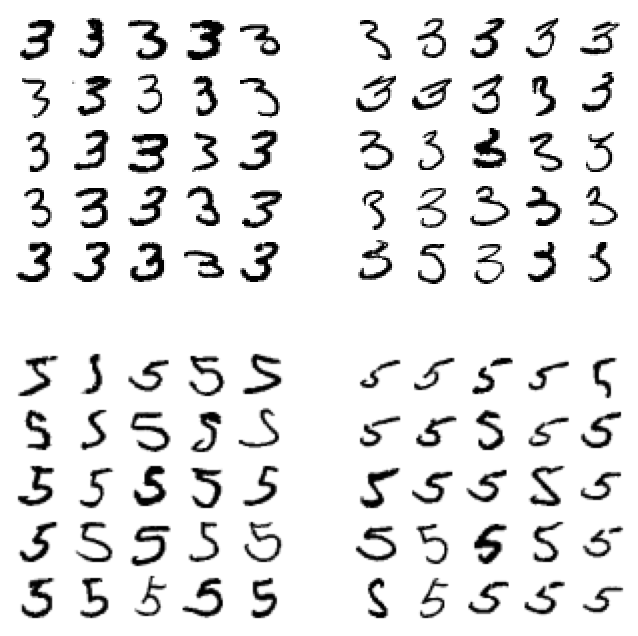

In [9]:
cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row = 5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row = 5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row = 5)
plt.show()

In [16]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


0.9764102655606048

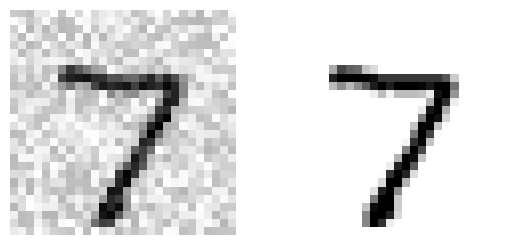

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


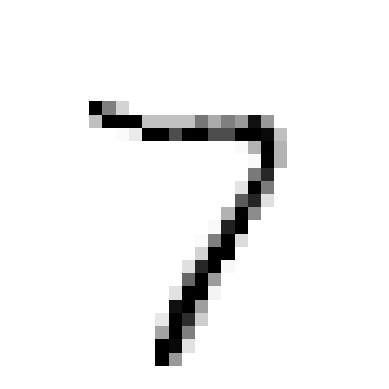

In [20]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

some_index = 0
plt.subplot(121)
plot_digit(X_test_mod.iloc[some_index].to_numpy())
plt.subplot(122)
plot_digit(y_test_mod.iloc[some_index].to_numpy())
plt.show()

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[some_index].to_numpy()])
plot_digit(clean_digit)